**Problem 1: Raw Data Processing & Problem 2: Feature Engineering**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
from sklearn import preprocessing

meta_file=pd.read_csv('/kaggle/input/stock-market-dataset/symbols_valid_meta.csv')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

counter=0
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_path=os.path.join(dirname, filename)
        print(data_path)
        if counter==200:
            break
        counter=counter+1
        if data_path != '/kaggle/input/stock-market-dataset/symbols_valid_meta.csv':             
            file = pd.read_csv(data_path,na_values=["null"],index_col="Date",parse_dates=True,infer_datetime_format=True)                            
            file['Symbol'] = filename.replace('.csv','')
            file= pd.merge(file, meta_file[['Security Name','Symbol']], how='left', left_on='Symbol', right_on='Symbol')
        
            file.to_parquet('sm_data.parquet')

            
            # Calculate the moving average
            file['vol_moving_avg'] = file.Volume.rolling(30).mean()            
            # Calculate the rolling median
            file['adj_close_rolling_med'] = file['Adj Close'].rolling(30).median()
            
            file.to_parquet('sm_data.parquet')
            file.to_csv('sm_data.csv')
            df=None
            if df is None: 
                df=file
            else:
                df=pd.concat([df,file])
            df.to_csv('sm_data.csv')
            
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserve

/kaggle/input/stock-market-dataset/symbols_valid_meta.csv
/kaggle/input/stock-market-dataset/stocks/MTL.csv
/kaggle/input/stock-market-dataset/stocks/JOE.csv
/kaggle/input/stock-market-dataset/stocks/DRE.csv
/kaggle/input/stock-market-dataset/stocks/CTY.csv
/kaggle/input/stock-market-dataset/stocks/AMSF.csv
/kaggle/input/stock-market-dataset/stocks/IMH.csv
/kaggle/input/stock-market-dataset/stocks/GFL.csv
/kaggle/input/stock-market-dataset/stocks/CLM.csv
/kaggle/input/stock-market-dataset/stocks/UBER.csv
/kaggle/input/stock-market-dataset/stocks/NEBU.csv
/kaggle/input/stock-market-dataset/stocks/SGB.csv
/kaggle/input/stock-market-dataset/stocks/WWW.csv
/kaggle/input/stock-market-dataset/stocks/UTSI.csv
/kaggle/input/stock-market-dataset/stocks/PBB.csv
/kaggle/input/stock-market-dataset/stocks/UFCS.csv
/kaggle/input/stock-market-dataset/stocks/ZM.csv
/kaggle/input/stock-market-dataset/stocks/DCPH.csv
/kaggle/input/stock-market-dataset/stocks/HALL.csv
/kaggle/input/stock-market-dataset/s

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3556 entries, 0 to 3555
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   3556 non-null   float64
 1   High                   3556 non-null   float64
 2   Low                    3556 non-null   float64
 3   Close                  3556 non-null   float64
 4   Adj Close              3556 non-null   float64
 5   Volume                 3556 non-null   int64  
 6   Symbol                 3556 non-null   object 
 7   Security Name          3556 non-null   object 
 8   vol_moving_avg         3527 non-null   float64
 9   adj_close_rolling_med  3527 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 305.6+ KB


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,vol_moving_avg,adj_close_rolling_med
count,3556.000000,3556.000000,3556.000000,3556.000000,3556.000000,3.556000e+03,3527.000000,3527.000000
mean,5.071302,5.165430,4.977747,5.077792,5.077792,5.582447e+04,55422.614120,5.068460
std,3.155202,3.221552,3.096193,3.168965,3.168965,1.272668e+05,57990.545606,3.146503
min,0.860000,0.860000,0.760000,0.840000,0.840000,0.000000e+00,1670.000000,0.910000
25%,3.080000,3.137500,3.030000,3.080000,3.080000,7.000000e+03,18036.666667,3.120000
50%,4.195000,4.290000,4.125000,4.225000,4.225000,2.210000e+04,34380.000000,4.250000
75%,6.150000,6.200000,6.100000,6.150000,6.150000,5.655000e+04,70065.000000,6.115000
max,16.730000,17.639999,15.900000,16.620001,16.620001,2.529000e+06,352716.666667,14.790000


In [5]:
df.isnull().sum()

Open                      0
High                      0
Low                       0
Close                     0
Adj Close                 0
Volume                    0
Symbol                    0
Security Name             0
vol_moving_avg           29
adj_close_rolling_med    29
dtype: int64

In [6]:
df.sort_index(inplace=True)

os.makedirs('/kaggle/working/stage/directory')

print(df.shape)
print(df.head())

# Retain the resulting dataset into the same format as Problem 1
df.to_parquet('stage/directory/sm_data_fe.parquet')
df.to_csv('stage/directory/sm_data_fe.csv')

(3556, 10)
   Open  High   Low  Close  Adj Close  Volume Symbol  \
0  7.50  7.70  7.50   7.70       7.70    1100    LOV   
1  7.70  7.75  7.70   7.75       7.75     300    LOV   
2  7.75  7.75  7.45   7.60       7.60    7200    LOV   
3  7.60  7.60  7.60   7.60       7.60    4900    LOV   
4  7.50  7.50  7.35   7.35       7.35    3500    LOV   

                                       Security Name  vol_moving_avg  \
0  Spark Networks, Inc. American Depositary Share...             NaN   
1  Spark Networks, Inc. American Depositary Share...             NaN   
2  Spark Networks, Inc. American Depositary Share...             NaN   
3  Spark Networks, Inc. American Depositary Share...             NaN   
4  Spark Networks, Inc. American Depositary Share...             NaN   

   adj_close_rolling_med  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  


In [7]:
# Data cleaning
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)


df.to_parquet('sm_data_clean.parquet')
df.to_csv('sm_data_clean.csv')

df=df.drop('Symbol',axis=1)
print(df.head())

df=df[['vol_moving_avg', 'adj_close_rolling_med','Volume' ]]

print(df.head(50))
    

    Open  High   Low  Close  Adj Close  Volume  \
29  6.80  6.80  6.70    6.7        6.7     900   
30  6.70  6.70  6.70    6.7        6.7    1000   
31  6.75  6.80  6.75    6.8        6.8     700   
32  6.80  6.95  6.80    6.9        6.9    4200   
33  7.00  7.00  7.00    7.0        7.0     400   

                                        Security Name  vol_moving_avg  \
29  Spark Networks, Inc. American Depositary Share...     2006.666667   
30  Spark Networks, Inc. American Depositary Share...     2003.333333   
31  Spark Networks, Inc. American Depositary Share...     2016.666667   
32  Spark Networks, Inc. American Depositary Share...     1916.666667   
33  Spark Networks, Inc. American Depositary Share...     1766.666667   

    adj_close_rolling_med  
29                   7.10  
30                   7.10  
31                   7.05  
32                   7.00  
33                   7.00  
    vol_moving_avg  adj_close_rolling_med  Volume
29     2006.666667                  7.100 

In [8]:
df.isnull().sum()

vol_moving_avg           0
adj_close_rolling_med    0
Volume                   0
dtype: int64

In [9]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns

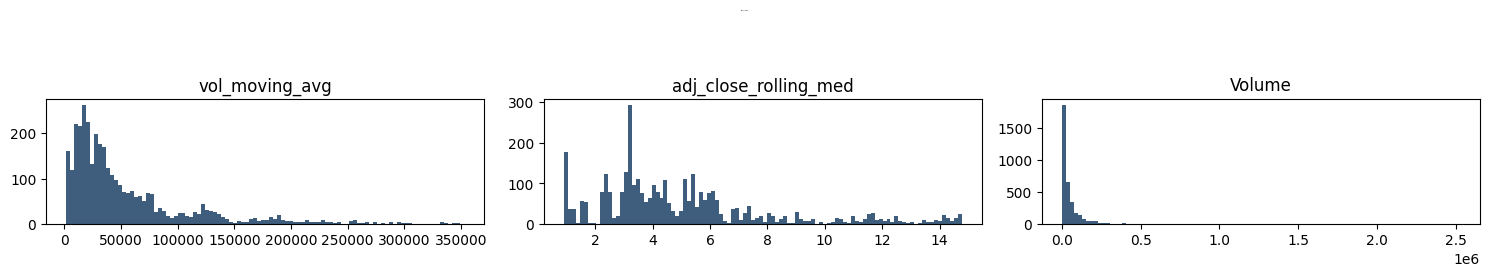

In [10]:
fig = plt.figure(figsize=(15, 12))

plt.suptitle('Histograms', fontsize=1)
for i in range(df.shape[1]):
    plt.subplot(6, 3, i + 1)
    f = plt.gca()
    f.set_title(df.columns.values[i])

    vals = np.size(df.iloc[:, i].unique())
    if vals >= 100:
        vals = 100

    plt.hist(df.iloc[:, i], bins=vals, color='#3F5D7D')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

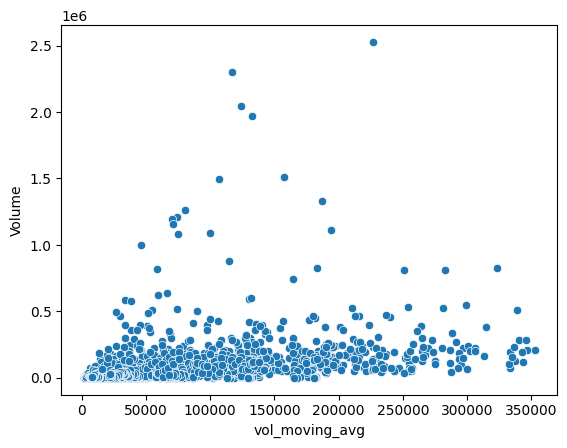

In [11]:
sns.scatterplot(x=df['vol_moving_avg'], y=df['Volume'])
plt.show()

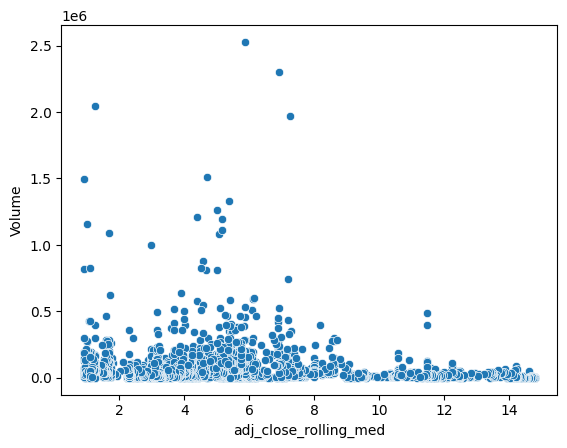

In [13]:
sns.scatterplot(x=df['adj_close_rolling_med'], y=df['Volume'])
plt.show()

**Problem 3: Integrate ML Training**

In [14]:
from sklearn import datasets, linear_model
from sklearn import metrics 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [15]:
x = df[:int(df.shape[0]*0.8)]
y = df[int(df.shape[0]*0.8):]

In [16]:
def regres(model, x, y):
    x_train, y_train =  x.iloc[:,:-1],x.iloc[:,-1]
    x_test, y_test =  y.iloc[:,:-1],y.iloc[:,-1]    
    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [17]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
regres(model, x, y)

Mean Absolute Error:  72344.63288479697
Mean Squared Error:  26311741155.222744
Root Mean Squared Error:  162208.94289533712


In [18]:
from xgboost import XGBRegressor
model=XGBRegressor(gamma=0.0453032172664104,
 learning_rate= 0.2155158027999262,
 max_depth= 5,
 n_estimators= 102,
 subsample= 0.9439761626945282)

regres(model, x, y)


Mean Absolute Error:  67770.60846241203
Mean Squared Error:  26995508081.693985
Root Mean Squared Error:  164303.09821087972


In [19]:
from lightgbm import LGBMRegressor
model=LGBMRegressor()
regres(model, x, y)

Mean Absolute Error:  59760.48556503712
Mean Squared Error:  20630965780.610085
Root Mean Squared Error:  143634.83484381525


In [20]:
x_train, y_train =  x.iloc[:,:-1],x.iloc[:,-1]
x_test, y_test =  y.iloc[:,:-1],y.iloc[:,-1] 
model.fit(x_train, y_train)

# Make predictions on test data
final_y_pred = model.predict(x_test)

#Save the resulting model to disk.
np.savetxt('final_pred.csv',final_y_pred ,delimiter=',')


In [21]:
from joblib import dump, load

# Pickle file to maintain structure 
dump(model, 'model.pkl') 

['model.pkl']

In [ ]:
"""import streamlit as st
import pickle

file= open('model.pkl')
rf=pickle.load()

st.title("Predictor")

query = np.array([vol_moving_avg, adj_close_rolling_med])

prediction = int(np.exp(rf.predict(query)[0]))

st.title("Predicted trading volume " + prediction)"""